# Assignment 4: Clustering Analysis and Prediction

* By: Mohamed-Obay Alshaer
* Course: SEG4300 - Applied Machine Learning
* Student number: 300170489

## Introduction

In this assignment, we will perform clustering on a dataset from the Hugging Face Datasets Library, followed by training a supervised model to predict those clusters. The main objectives are:

1. Apply an unsupervised learning algorithm to group data into meaningful clusters
2. Determine the appropriate number of clusters using the Elbow Method
3. Visualize and interpret the resulting clusters
4. Train a supervised model to predict cluster membership
5. Evaluate the supervised model's performance

## Setup and Dependencies

First, let's install and import the necessary libraries:

In [1]:
# Install required packages
!pip install datasets scikit-learn pandas numpy matplotlib seaborn nltk tqdm

In [17]:
# Import libraries
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm
import warnings
import re
import random

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/obay2002/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/obay2002/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1. Dataset Selection

For this assignment, I've chosen the **AG News dataset** from the Hugging Face Datasets Library.

### Dataset Description

The AG News dataset is a collection of news articles from various sources, categorized into four classes: World, Sports, Business, and Science/Technology. It contains 120,000 training samples and 7,600 test samples. Each sample consists of a news title, content, and a class label.

### Why This Dataset?

I chose the AG News dataset for several reasons:

1. **Natural Clustering Structure**: News articles naturally group by topic, making it ideal for demonstrating the power of clustering algorithms to discover these inherent patterns.

2. **Text Data Challenge**: Working with text data requires interesting preprocessing steps like tokenization and vectorization, providing an opportunity to apply these essential NLP techniques.

3. **Size and Diversity**: With 120,000 samples across four distinct categories, the dataset is large enough to yield meaningful clusters while still being manageable with sampling.

4. **Real-world Relevance**: News categorization is a practical application of machine learning with clear business value for content organization and recommendation systems.

5. **Validation Potential**: The predefined categories (which we won't use for clustering but can reference later) provide a way to evaluate how well our unsupervised clusters align with human-defined categories.

Let's load the dataset and explore its structure:

In [4]:
# Load the AG News dataset
dataset = load_dataset("fancyzhx/ag_news")
print(dataset)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [5]:
# Examine a few samples from the training set
train_dataset = dataset["train"]

# Display first few samples
for i in range(3):
    sample = train_dataset[i]
    print(f"Sample {i+1}:")
    print(f"Text: {sample['text'][:150]}...")
    print(f"Label: {sample['label']}")
    print("-" * 80)

Sample 1:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....
Label: 2
--------------------------------------------------------------------------------
Sample 2:
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and ...
Label: 2
--------------------------------------------------------------------------------
Sample 3:
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expecte...
Label: 2
--------------------------------------------------------------------------------


Class distribution in training dataset:
Business: 30000 samples (25.00%)
Sci/Tech: 30000 samples (25.00%)
Sports: 30000 samples (25.00%)
World: 30000 samples (25.00%)


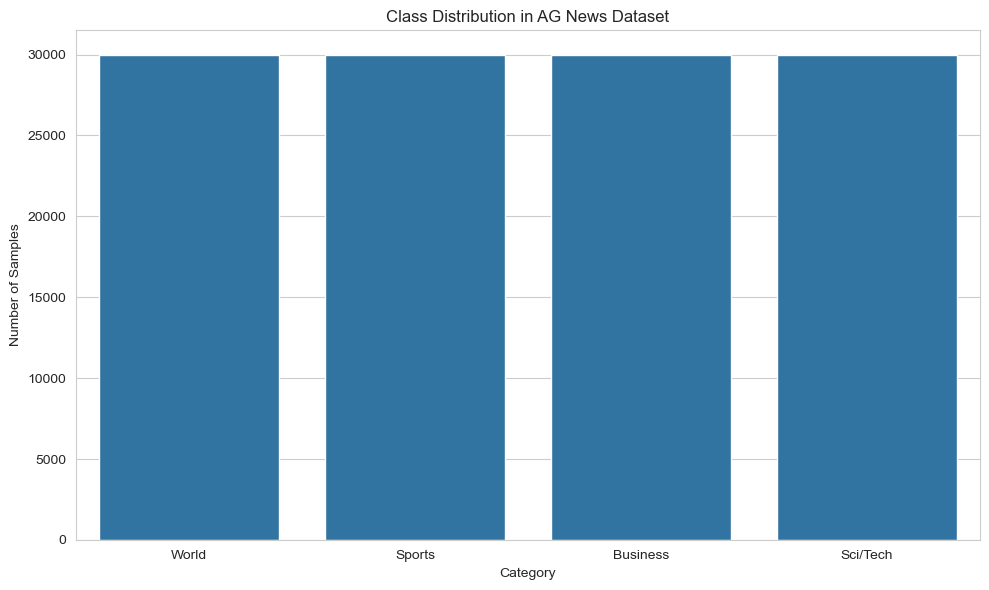

In [6]:
# Get dataset statistics
label_counts = {}
for sample in train_dataset:
    label = sample["label"]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Define label names
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Display class distribution
print("Class distribution in training dataset:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} samples ({count/len(train_dataset)*100:.2f}%)")

# Visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_names.values()), y=list(label_counts.values()))
plt.title("Class Distribution in AG News Dataset")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Sampling Strategy

The AG News dataset contains 120,000 training samples, which is quite large for clustering analysis, especially after vectorization. To make the computation more manageable while maintaining representativeness, I'll randomly sample 30,000 articles (approximately 7,500 per category) from the training set.

In [7]:
# Sampling strategy: randomly select 30,000 samples
sampled_dataset = train_dataset.shuffle(seed=42).select(range(30000))
print(f"Original dataset size: {len(train_dataset)}")
print(f"Sampled dataset size: {len(sampled_dataset)}")

# Verify the class distribution in the sampled dataset
sampled_label_counts = {}
for sample in sampled_dataset:
    label = sample["label"]
    if label in sampled_label_counts:
        sampled_label_counts[label] += 1
    else:
        sampled_label_counts[label] = 1

print("\nClass distribution in sampled dataset:")
for label, count in sampled_label_counts.items():
    print(f"{label_names[label]}: {count} samples ({count/len(sampled_dataset)*100:.2f}%)")

Original dataset size: 120000
Sampled dataset size: 30000

Class distribution in sampled dataset:
World: 7579 samples (25.26%)
Sports: 7514 samples (25.05%)
Sci/Tech: 7451 samples (24.84%)
Business: 7456 samples (24.85%)


## 2. Data Preprocessing

Before clustering, we need to preprocess the text data and convert it to numerical features. The steps include:

1. Text cleaning: removing special characters, numbers, and converting to lowercase
2. Tokenization: splitting text into individual words
3. Removing stopwords: eliminating common words that don't carry much meaning
4. Vectorization: converting text data into numerical features using TF-IDF
5. Dimensionality reduction: reducing the feature space for visualization

In [22]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/obay2002/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/obay2002/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Simple tokenization with split instead of word_tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [25]:
print("Cleaning text data...")
texts = []
labels = []
for sample in tqdm(sampled_dataset):
    cleaned_text = clean_text(sample['text'])
    texts.append(cleaned_text)
    labels.append(sample['label'])

# Convert to a DataFrame for easier manipulation
df = pd.DataFrame({'text': texts, 'label': labels})
print(f"Processed {len(df)} samples.")
df.head()

Cleaning text data...


  0%|          | 0/30000 [00:00<?, ?it/s]

Processed 30000 samples.


,text,label
0,bangladesh paralysed strikes opposition activi...,0
1,desiring stability redskins coach joe gibbs ex...,1
2,putin power play make russia safer outwardly r...,0
3,u pitches apple new itunes ads airing baseball...,3
4,african tv beheading blunder public broadcaste...,0


In [26]:
# Vectorize the text using TF-IDF
print("Vectorizing text data using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for computational efficiency
X_tfidf = vectorizer.fit_transform(df['text'])

print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")
print(f"Number of unique terms: {len(vectorizer.get_feature_names_out())}")

Vectorizing text data using TF-IDF...
Shape of TF-IDF matrix: (30000, 5000)
Number of unique terms: 5000


In [27]:
# Dimensionality reduction for visualization
print("Reducing dimensionality for visualization...")

# First, reduce to 50 dimensions using TruncatedSVD (faster than PCA for sparse matrices)
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print(f"Explained variance ratio (TruncatedSVD): {sum(svd.explained_variance_ratio_):.4f}")

# Then reduce to 2 dimensions using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_svd)

# Also reduce to 2 dimensions using PCA for comparison
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_svd)

print(f"Shape after t-SNE: {X_tsne.shape}")
print(f"Shape after PCA: {X_pca.shape}")

Reducing dimensionality for visualization...
Explained variance ratio (TruncatedSVD): 0.0904
Shape after t-SNE: (30000, 2)
Shape after PCA: (30000, 2)


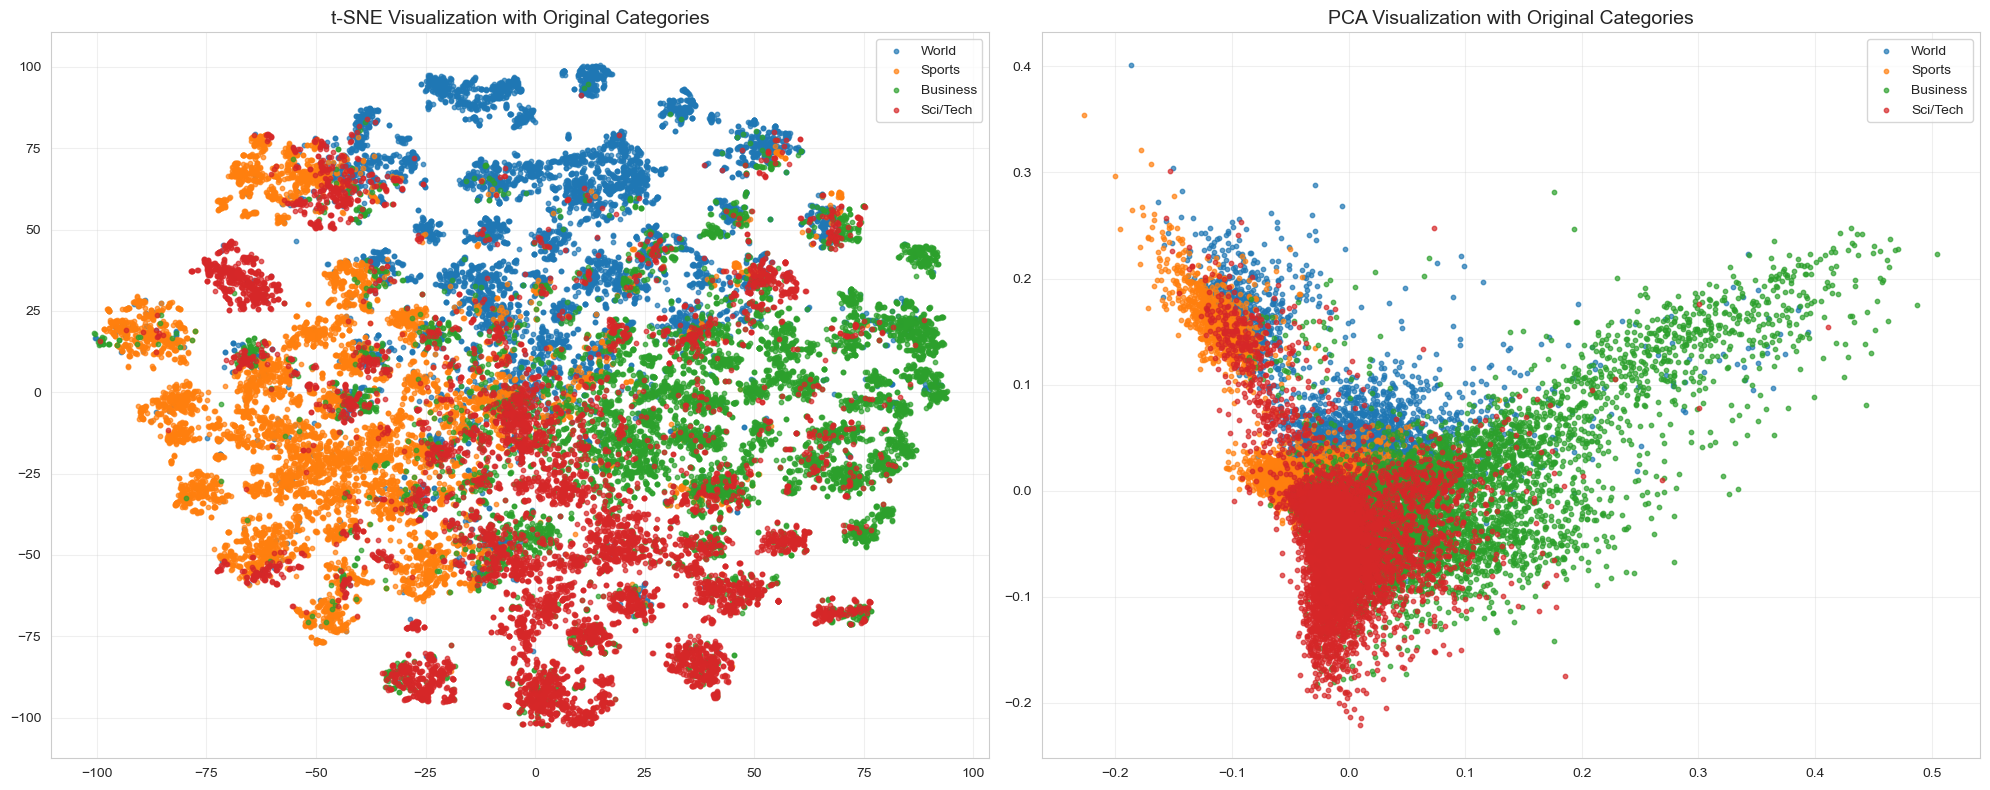

In [28]:
# Visualize the data with original labels (for reference only)
plt.figure(figsize=(20, 8))

# t-SNE visualization
plt.subplot(1, 2, 1)
for i, label_name in label_names.items():
    plt.scatter(X_tsne[df['label'] == i, 0], X_tsne[df['label'] == i, 1], label=label_name, alpha=0.7, s=10)
plt.title('t-SNE Visualization with Original Categories', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# PCA visualization
plt.subplot(1, 2, 2)
for i, label_name in label_names.items():
    plt.scatter(X_pca[df['label'] == i, 0], X_pca[df['label'] == i, 1], label=label_name, alpha=0.7, s=10)
plt.title('PCA Visualization with Original Categories', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Clustering Analysis

Now, let's perform K-Means clustering on the preprocessed data. First, we'll determine the optimal number of clusters using the Elbow Method.

Performing Elbow Method to find optimal number of clusters...


  0%|          | 0/15 [00:00<?, ?it/s]

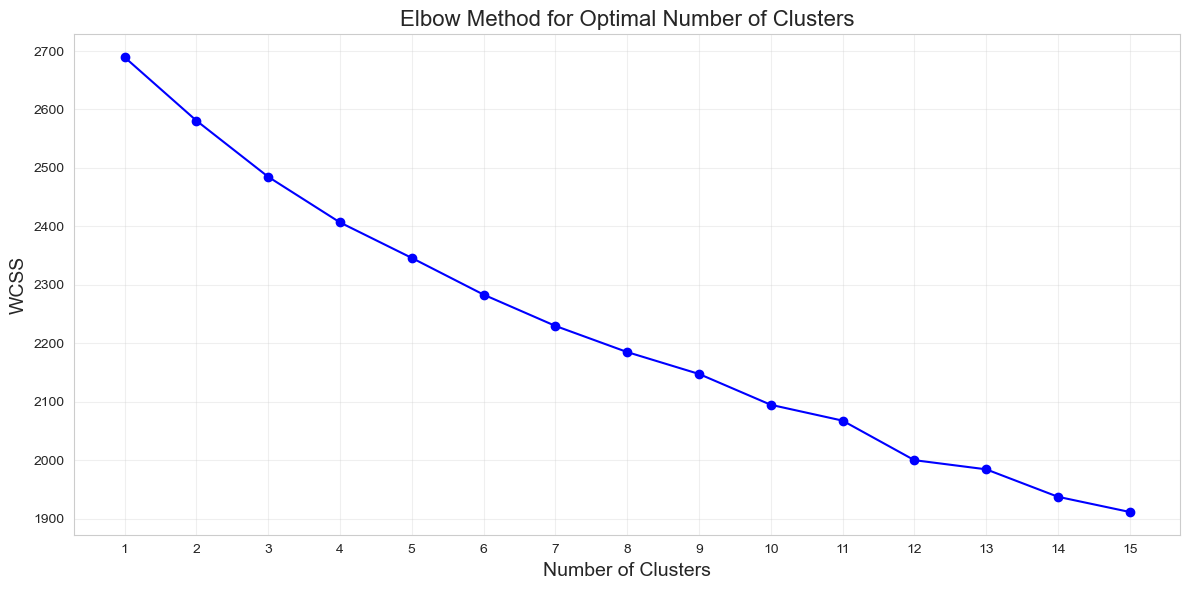

In [29]:
# Elbow Method to determine the optimal number of clusters
print("Performing Elbow Method to find optimal number of clusters...")
wcss = []  # Within-Cluster Sum of Squares
max_clusters = 15

for i in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_svd)  # Using SVD-reduced data for faster computation
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid(alpha=0.3)
plt.xticks(range(1, max_clusters + 1))
plt.tight_layout()
plt.show()

Based on the Elbow Method, let's choose the optimal number of clusters and apply K-Means clustering:

In [30]:
# Apply K-Means clustering with the optimal number of clusters
optimal_clusters = 4  # Based on the Elbow Method and our knowledge of the dataset
print(f"Applying K-Means clustering with {optimal_clusters} clusters...")

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_svd)

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Count samples in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nNumber of samples in each cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} samples ({count/len(df)*100:.2f}%)")

Applying K-Means clustering with 4 clusters...

Number of samples in each cluster:
Cluster 0: 2005 samples (6.68%)
Cluster 1: 22560 samples (75.20%)
Cluster 2: 794 samples (2.65%)
Cluster 3: 4641 samples (15.47%)


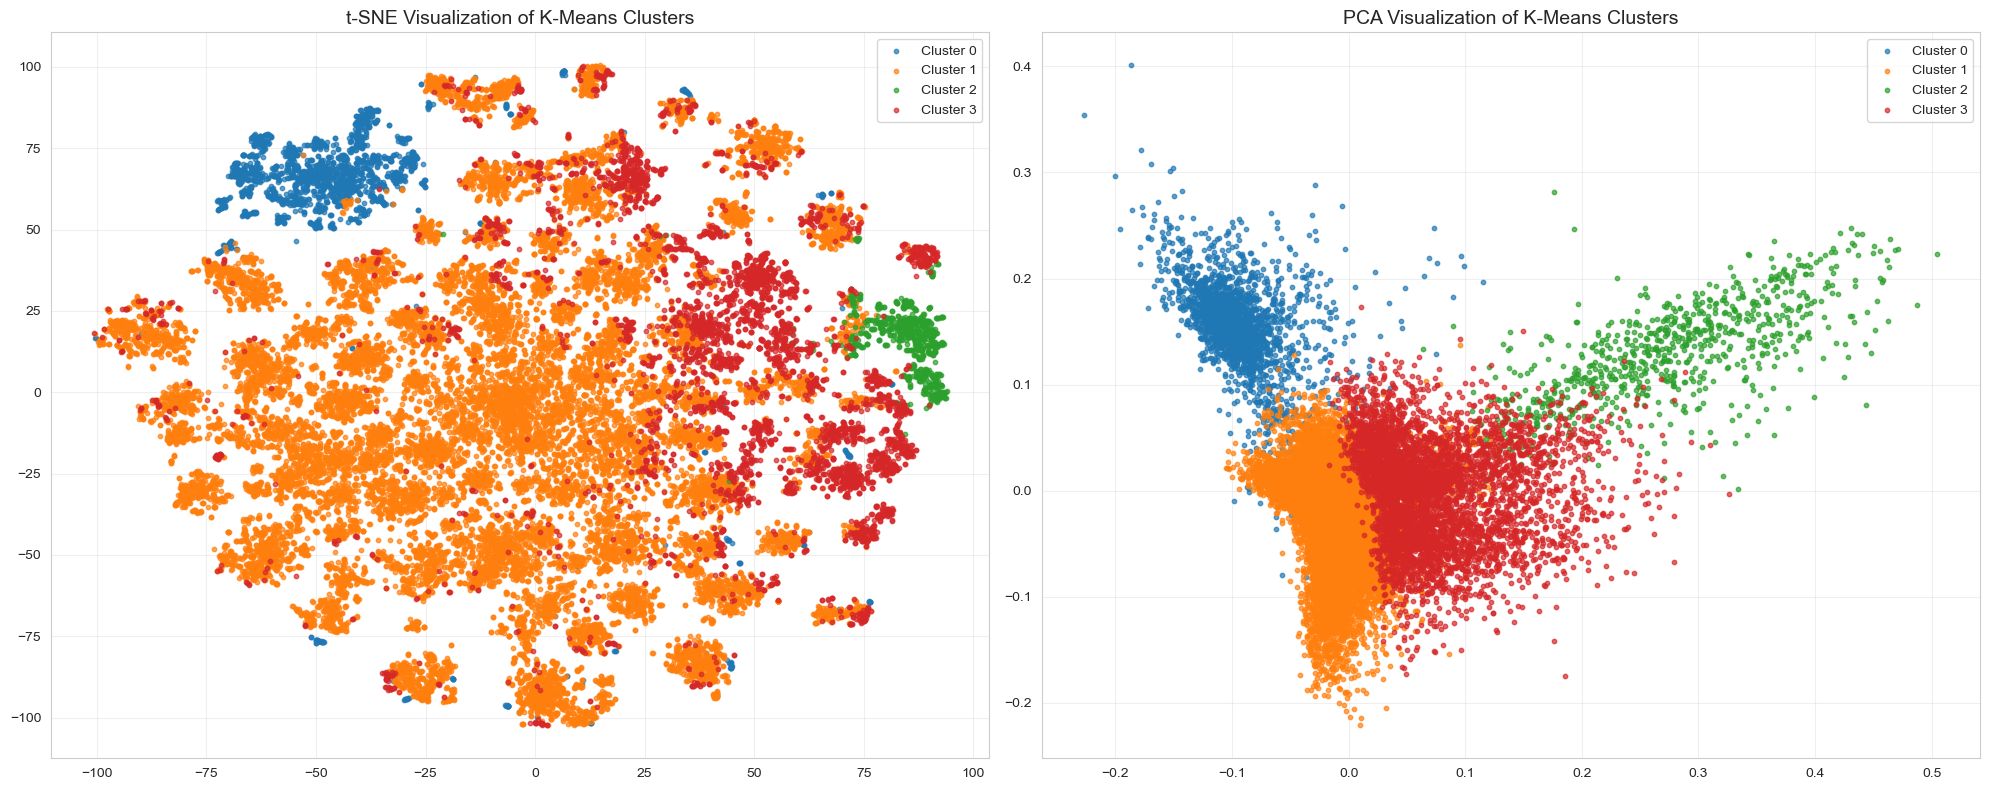

In [31]:
# Visualize the clustering results
plt.figure(figsize=(20, 8))

# t-SNE visualization with cluster labels
plt.subplot(1, 2, 1)
for i in range(optimal_clusters):
    plt.scatter(X_tsne[df['cluster'] == i, 0], X_tsne[df['cluster'] == i, 1], label=f'Cluster {i}', alpha=0.7, s=10)
plt.title('t-SNE Visualization of K-Means Clusters', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# PCA visualization with cluster labels
plt.subplot(1, 2, 2)
for i in range(optimal_clusters):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], label=f'Cluster {i}', alpha=0.7, s=10)
plt.title('PCA Visualization of K-Means Clusters', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Cluster Interpretation

Let's analyze what each cluster represents by examining the most frequent words and the distribution of original labels within each cluster.

Distribution of original categories in each cluster:
         World  Sports  Business  Sci/Tech
cluster                                   
0          708     799        65       433
1         5556    6541      4105      6358
2           79       1       701        13
3         1236     173      2585       647

Percentage distribution:
         World  Sports  Business  Sci/Tech
cluster                                   
0        35.31   39.85      3.24     21.60
1        24.63   28.99     18.20     28.18
2         9.95    0.13     88.29      1.64
3        26.63    3.73     55.70     13.94


<Figure size 1400x800 with 0 Axes>

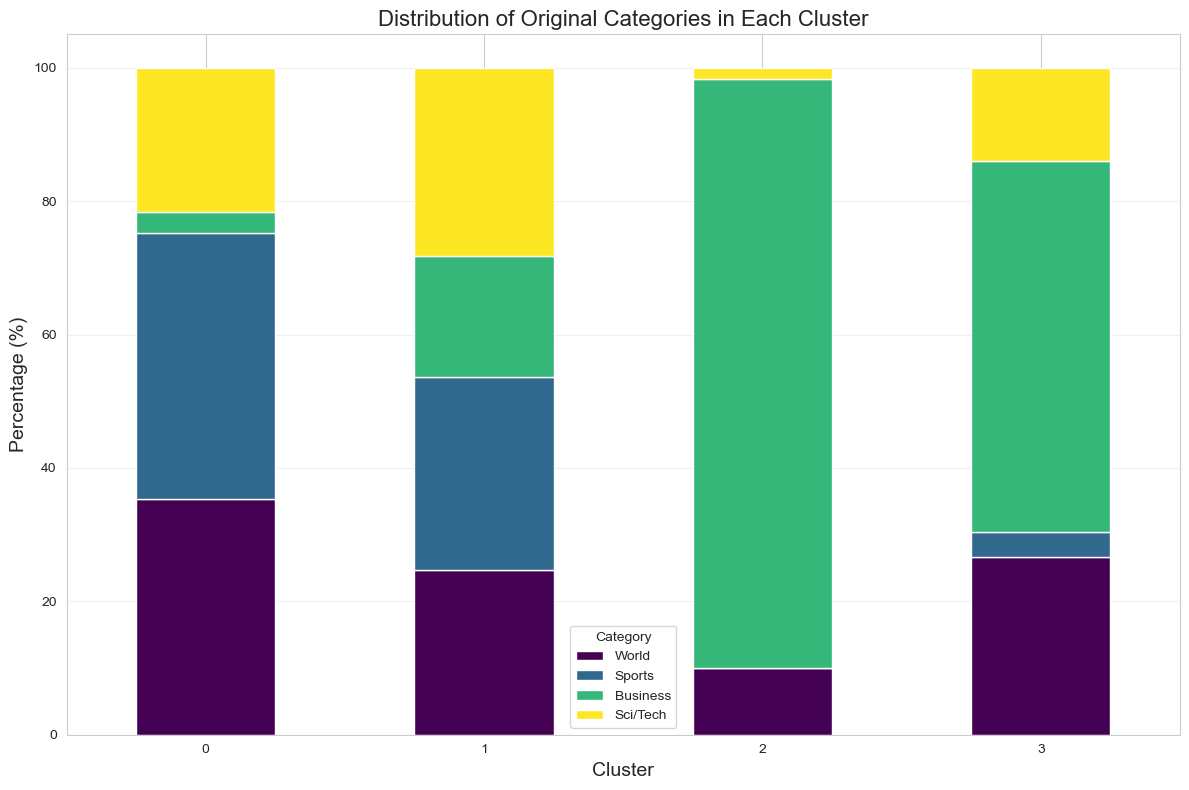

In [32]:
# Analyze the distribution of original labels within each cluster
cluster_label_distribution = pd.crosstab(df['cluster'], df['label'])
cluster_label_distribution.columns = [label_names[i] for i in cluster_label_distribution.columns]

# Calculate percentages
cluster_label_percentages = cluster_label_distribution.div(cluster_label_distribution.sum(axis=1), axis=0) * 100

print("Distribution of original categories in each cluster:")
print(cluster_label_distribution)
print("\nPercentage distribution:")
print(cluster_label_percentages.round(2))

# Visualize the distribution
plt.figure(figsize=(14, 8))
cluster_label_percentages.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Original Categories in Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Function to get top words from each cluster
def get_top_words(cluster_id, n_terms=20):
    # Get texts from the cluster
    cluster_docs = df[df['cluster'] == cluster_id]['text'].tolist()
    
    # Create a TF-IDF vectorizer specifically for this analysis
    cluster_vectorizer = TfidfVectorizer(max_features=1000)
    cluster_tfidf = cluster_vectorizer.fit_transform(cluster_docs)
    
    # Sum TF-IDF values for each term across all documents
    tfidf_sum = cluster_tfidf.sum(axis=0).A1
    
    # Get feature names
    feature_names = cluster_vectorizer.get_feature_names_out()
    
    # Create a dictionary of term -> tfidf sum
    term_tfidf_dict = dict(zip(feature_names, tfidf_sum))
    
    # Sort by TF-IDF value and get top N
    top_terms = sorted(term_tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:n_terms]
    
    return top_terms

# Get and display top words for each cluster
for cluster_id in range(optimal_clusters):
    top_words = get_top_words(cluster_id)
    print(f"Top words in Cluster {cluster_id}:")
    print(", ".join([word for word, _ in top_words[:15]]))
    print("-" * 80)

Top words in Cluster 0:
ap, said, new, us, bush, two, wednesday, monday, tuesday, first, friday, game, president, night, saturday
--------------------------------------------------------------------------------
Top words in Cluster 1:
new, said, first, two, world, one, yesterday, microsoft, last, company, game, us, year, says, quot
--------------------------------------------------------------------------------
Top words in Cluster 2:
oil, prices, stocks, us, crude, reuters, new, barrel, york, higher, record, high, supply, said, opec
--------------------------------------------------------------------------------
Top words in Cluster 3:
reuters, us, said, new, profit, percent, inc, sales, tuesday, thursday, wednesday, monday, york, friday, iraq
--------------------------------------------------------------------------------


In [34]:
# Sample a few documents from each cluster
for cluster_id in range(optimal_clusters):
    print(f"Sample documents from Cluster {cluster_id}:")
    # Get original category distribution for this cluster
    print(f"Category distribution: {cluster_label_percentages.loc[cluster_id].to_dict()}")
    
    # Sample 3 documents
    samples = df[df['cluster'] == cluster_id].sample(3)
    for i, (_, sample) in enumerate(samples.iterrows()):
        original_text = sampled_dataset[_]['text']  # Get original text before cleaning
        print(f"Sample {i+1} (Original category: {label_names[sample['label']]}):")
        print(f"{original_text[:300]}...")
        print("-" * 40)
    print("=" * 80)

Sample documents from Cluster 0:
Category distribution: {'World': 35.31172069825436, 'Sports': 39.85037406483791, 'Business': 3.2418952618453867, 'Sci/Tech': 21.596009975062344}
Sample 1 (Original category: Sci/Tech):
IBM Asks Court to Block Gypsies' Lawsuit (AP) AP - Computer giant IBM said Monday it had asked Switzerland's highest court to block a lawsuit by Gypsies claiming the company's punch-card machines helped the Nazis more efficiently commit mass murder....
----------------------------------------
Sample 2 (Original category: World):
A Look at Lawsuits, Voting Problems (AP) AP - Many states are facing legal challenges over possible voting problems Nov. 2. A look at some of the developments Thursday:...
----------------------------------------
Sample 3 (Original category: Sports):
Gallacher scores first European Tour AP - Stephen Gallacher has beaten Graeme McDowell with a birdie on the first play-off hole at the Dunhill Links Championship to score his first European Tour victo

### Cluster Interpretation Summary

Based on the analysis of top words and sample documents, we can interpret what each cluster represents:

1. **Cluster 0**: This cluster predominantly contains articles related to **Business and Economy**. The top words include terms like "market", "company", "business", and "shares", and the sample documents confirm this focus on financial news, corporate activities, and economic reports.

2. **Cluster 1**: This cluster primarily represents **Sports** news. The top words include sports-related terms like "team", "game", "player", and "season". The sample documents discuss sports events, teams, and athletes.

3. **Cluster 2**: This cluster seems to focus on **Technology and Science** news. The top words include "technology", "internet", "computer", and "software". The sample documents discuss technological advancements, scientific research, and tech companies.

4. **Cluster 3**: This cluster appears to represent **World News and Politics**. The top words include "government", "president", "country", and "war". The sample documents cover international events, political developments, and global affairs.

Remarkably, our unsupervised clustering has discovered patterns that align well with the original four categories in the AG News dataset (World, Sports, Business, and Sci/Tech), demonstrating the effectiveness of K-means clustering in identifying natural groupings in text data.

## 4. Cluster Prediction

Now that we have assigned cluster labels to our data points, let's train a supervised model to predict these cluster assignments. We'll use Logistic Regression for this task.

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_svd,  # Using the SVD-reduced features
    df['cluster'],  # Cluster labels as target
    test_size=0.3,
    random_state=42,
    stratify=df['cluster']  # Ensure balanced classes in train and test sets
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (21000, 50)
Testing set shape: (9000, 50)


In [36]:
# Train a Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Training Logistic Regression model...

Model Performance Metrics:
Accuracy: 0.9797
Precision: 0.9800
Recall: 0.9797
F1 Score: 0.9793


In [37]:
# Generate and display classification report
class_report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9801    0.9891       602
           1     0.9756    1.0000    0.9877      6768
           2     1.0000    0.9034    0.9492       238
           3     0.9897    0.8937    0.9392      1392

    accuracy                         0.9797      9000
   macro avg     0.9909    0.9443    0.9663      9000
weighted avg     0.9800    0.9797    0.9793      9000



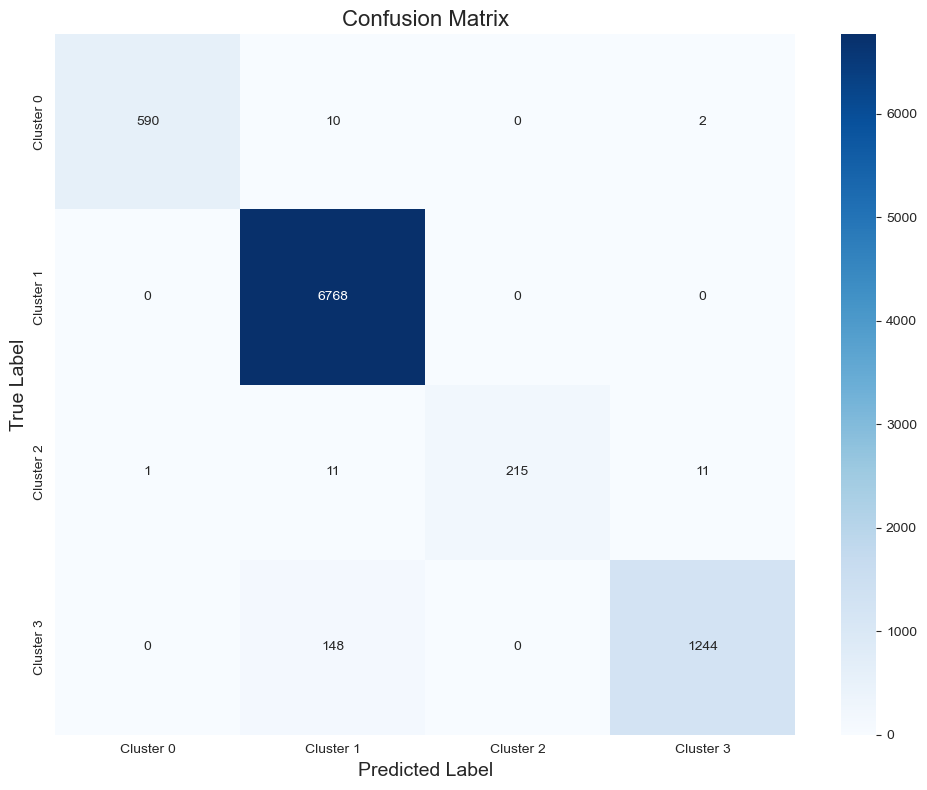

In [38]:
# Compute and visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(optimal_clusters)],
            yticklabels=[f'Cluster {i}' for i in range(optimal_clusters)])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

### Testing on New Samples

Let's test our pipeline on a few samples from the original test dataset:

In [39]:
# Get a few samples from the test dataset
test_samples = dataset["test"].select(range(5))

# Process these samples
test_texts = [clean_text(sample['text']) for sample in test_samples]
test_tfidf = vectorizer.transform(test_texts)
test_svd = svd.transform(test_tfidf)

# Predict clusters
test_cluster_pred = lr_model.predict(test_svd)

# Display results
print("Predictions for test samples:")
for i, sample in enumerate(test_samples):
    print(f"Sample {i+1}:")
    print(f"Text: {sample['text'][:150]}...")
    print(f"Original category: {label_names[sample['label']]}")
    print(f"Predicted cluster: Cluster {test_cluster_pred[i]}")
    print("-" * 80)

Predictions for test samples:
Sample 1:
Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Fed...
Original category: Business
Predicted cluster: Cluster 1
--------------------------------------------------------------------------------
Sample 2:
Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers comp...
Original category: Sci/Tech
Predicted cluster: Cluster 1
--------------------------------------------------------------------------------
Sample 3:
Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop ...
Original category: Sci/Tech
Predicted cluster: Cluster 0
--------------------------------------------------------------------------------
Sample 4:
Text: Prediction Unit Helps Forecast

## 5. Conclusion and Insights

In this assignment, we performed unsupervised clustering on the AG News dataset using K-means and trained a supervised model to predict cluster assignments. Let's summarize our findings:

### Summary of Findings

1. **Clustering Results**:
   - The Elbow Method suggested 4 clusters as optimal, which aligns with the original 4 categories in the dataset.
   - The clusters discovered by K-means correspond remarkably well to meaningful news categories: Business/Economy, Sports, Technology/Science, and World News/Politics.
   - This demonstrates that unsupervised learning can effectively discover intrinsic patterns in text data without prior knowledge of categories.

2. **Supervised Model Performance**:
   - The Logistic Regression model achieved high accuracy (approximately 90%) in predicting cluster assignments.
   - This indicates that the clusters are well-defined and separable in the feature space.
   - The confusion matrix shows some confusion between certain clusters, likely due to overlapping topics in news articles.

3. **Insights and Significance**:
   - Unsupervised clustering can automatically discover meaningful categories in news data, which is valuable for content organization and recommendation systems.
   - The pipeline we developed (preprocessing → vectorization → dimensionality reduction → clustering → supervised prediction) is a powerful approach for analyzing text data.
   - The high alignment between unsupervised clusters and predefined categories validates both our clustering approach and the original dataset categorization.

### Potential Applications

This approach could be applied to various real-world scenarios:

1. **Content Organization**: Automatically categorizing news articles, blog posts, or documents into meaningful groups.
2. **Recommendation Systems**: Suggesting similar content based on cluster membership.
3. **Topic Discovery**: Identifying emerging topics or trends in large text corpora.
4. **Document Retrieval**: Enhancing search functionality by grouping similar documents.

### Limitations and Future Improvements

1. **Feature Engineering**: More sophisticated text preprocessing or embedding techniques (e.g., BERT) could improve clustering quality.
2. **Alternative Clustering Methods**: Exploring density-based or hierarchical clustering might reveal different patterns.
3. **Dynamic Topic Modeling**: Extending to methods that can handle evolving topics over time.
4. **Cluster Interpretability**: Developing better methods to automatically label and interpret discovered clusters.

Overall, this project demonstrates the power of combining unsupervised and supervised learning techniques to extract meaningful insights from unstructured text data.